# Scene Recognition by Combining Local and Global Image Descriptors


**Approach** : We make use of global feature descriptors as well as local feature descriptors simultaneously to represent each image, to improve recognition accuracy. Our basic steps are as follows

**1. Feature Extraction** : From each image, we first extract DAISY features [1] corresponding to the keypoints detected from the image. We make use of the skimage library (scikit-image) [2] for feature extraction. Corresponding to each keypoint in the image, there would be a DAISY descriptor with dimensions controlled by the parameters step size (distance between descriptor sampling points) and radius (describing size of the scanning area). We also extract a standard HOG descriptor corresponding to the entire image at a different granularity (by making use of the parameters pixels_per_cell, cells_per_block and orientations), effectively allowing us to choose features at different scales.


**2. Encoding** : We make use of the local DAISY features corresponding to each keypoints, to perform the encoding. We use the standard "bag-of-visual-words" concept here. Concretely, we apply K-means algorithm to quantize DAISY features into 'K' clusters to form "visual words". Thus, K becomes the size of our vocabulary. Corresponding to each image, we construct a histogram with 'K' as the dimensionality, based on this vocabulary.


**3. Pooling** : We make use of a 2-level pooling scheme. From the DAISY features, we construct a histogram by representing frequency of each visual word in each image. We do this by taking each key point in the image and looking up the cluster_id corresponding to that DAISY descriptor and incrementing the count corresponding to that bin in our histogram. This procedure is effectively a "sum pooling". We do an L2 normalization of the resulting histogram to form a "DAISY histogram feature". For the 2nd level pooling, we take the HOG global descriptor corresponding to each image and do an L2 normalization followed by a concatenation with the corresponding DAISY histogram feature.


**4. Classification** : We make use of the standard SVM classifier with various kernels. We utilize the sckit-learn (sklearn) library [3] for the SVM implementations. We do cross-validation by randomly splitting the dataset into a training and testing set. We construct the "visual vocabulary" as well as training feature vectors from the training split. We report the overall accuracy, confusion-matrix as well as standard information-retrieval statistics such as Precision, Recall and F-measure.




#### REFERENCES ########

[1] Tola, Engin, Vincent Lepetit, and Pascal Fua. "A fast local descriptor for dense matching." Computer Vision and Pattern Recognition, 2008. CVPR 2008. IEEE Conference on. IEEE, 2008.

[2] Van der Walt, Stefan, et al. "scikit-image: image processing in Python." PeerJ 2 (2014): e453.

[3] Pedregosa, Fabian, et al. "Scikit-learn: Machine learning in Python." Journal of Machine Learning Research 12.Oct (2011): 2825-2830.


In case if you find our code to be helpful, please consider citing our paper http://arxiv.org/abs/1702.06850. Wilson, J., Arif, M. (2017). Scene Recognition by Combining Local and Global Image Descriptors. arXiv preprint arXiv:1702.06850.

In [1]:
### import required libraries ###
### file/folder manipulation ###
from urllib import urlretrieve
from os import listdir
from os.path import isfile, join, exists
from zipfile import ZipFile
##for random split of dataset into a training set and a test set ###
from sklearn.model_selection import train_test_split
## image processing routines for feature extraction/transformation##
from skimage.feature import daisy,hog
from skimage import io
from skimage.color import rgb2gray
import skimage
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

#### Download Dataset

In [2]:
if not exists('scene_categories/'):
    if not exists('scene_categories.zip'):
        print 'Downloading scene_categories.zip'
        urlretrieve ('http://www-cvr.ai.uiuc.edu/ponce_grp/data/scene_categories/scene_categories.zip', 'scene_categories.zip')
        print 'Downloaded scene_categories.zip'
    print 'Extracting scene_categories.zip'
    zipfile = ZipFile('scene_categories.zip', 'r')
    zipfile.extractall('./scene_categories')
    zipfile.close()
    print 'Extracted scene_categories.zip'
else:
    print 'Dataset already downloaded and extracted!'

Dataset already downloaded and extracted!


#### Get all the filenames (including the full path) in a folder as a list.

In [3]:
def get_filenames(path):
    onlyfiles = [path+f for f in listdir(path) if isfile(join(path, f))]
    return onlyfiles

#### Function to extract daisy features as well as hog features from an image

In [4]:
def extract_daisy_and_hog_features_from_image(file_path,daisy_step_size=32,daisy_radius=32,hog_pixels_per_cell=16,hog_cells_per_block=1):
    img = io.imread(file_path)
    img_gray = rgb2gray(img)
    img=skimage.transform.resize(img_gray,(300,250)) ##resize to a suitable dimension, avg size of images in the dataset
    #original, histograms=6
    descs = daisy(img, step=daisy_step_size, radius=daisy_radius, rings=2, histograms=8,orientations=8, visualize=False)
    #calculate daisy feature descriptors
    descs_num = descs.shape[0] * descs.shape[1]
    daisy_desriptors=descs.reshape(descs_num,descs.shape[2])
    hog_desriptor=hog(img, orientations=8, pixels_per_cell=(hog_pixels_per_cell, hog_pixels_per_cell),cells_per_block=(hog_cells_per_block, hog_cells_per_block), visualise=False,feature_vector=True)
    return daisy_desriptors,hog_desriptor
    
    

In [5]:
def plot_file(fname):
    img_data=plt.imread(fname)
    plt.imshow(rgb2gray(img_data),cmap='Greys_r')

DAISY descriptor size: (1080, 136)
HOG descriptor size: (2160,)


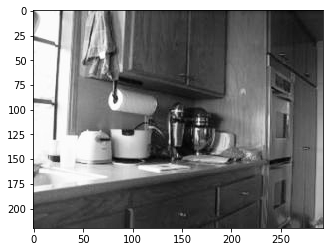

In [6]:
base_path="scene_categories/" ##path where image data is kept
## take a descriptor sample to show the shape of arrays ##
fname="kitchen/image_0001.jpg"
plot_file(base_path+fname)
#img_data=plt.imread(base_path+fname)
#plt.imshow(rgb2gray(img_data),cmap='Greys_r')
daisy_sample,hog_sample=extract_daisy_and_hog_features_from_image(base_path+fname,daisy_step_size=8,daisy_radius=8)
print 'DAISY descriptor size:',daisy_sample.shape
print 'HOG descriptor size:',hog_sample.shape

In [7]:
img_width=300
img_height=250
hog_pixels_per_cell=16
orientations=8
print 'HOG vector size=',(img_width/hog_pixels_per_cell)*(img_height/hog_pixels_per_cell)*orientations

HOG vector size= 2160


#### Load file names corresponding to each scene category into lists

In [8]:
category_names=listdir(base_path) ##
for i in range(len(category_names)):
    print category_names[i],'=',i
print 'total categories:',len(category_names)
dataset_filenames=[] ##list to keep path of all files in the database
dataset_labels=[]
##category_names.index('store')  list the numeric representation of the category
##category_names[0] list the text representation of the category id
for category in category_names:
    category_filenames=get_filenames(base_path+category+"/")##get all the filenames in that category
    category_labels=np.ones(len(category_filenames))*category_names.index(category) ##label the category with its index position
    dataset_filenames=dataset_filenames+category_filenames
    dataset_labels=dataset_labels+list(category_labels)

MITinsidecity = 0
bedroom = 1
PARoffice = 2
MITmountain = 3
MITtallbuilding = 4
MIThighway = 5
MITcoast = 6
livingroom = 7
industrial = 8
store = 9
MITopencountry = 10
MITstreet = 11
MITforest = 12
kitchen = 13
CALsuburb = 14
total categories: 15


In [9]:
print 'total dataset size:',len(dataset_filenames)

total dataset size: 4485


#### Split into training files and testing files

In [10]:
train_filenames,test_filenames,train_labels,test_labels=train_test_split(dataset_filenames,dataset_labels,test_size=0.6,random_state=42)
print 'total files in training split:',len(train_filenames)
print 'total files in testing split:',len(test_filenames)

total files in training split: 1794
total files in testing split: 2691


#### Extract features from training datasplit for downstream processing, takes aprox 12 mins for a standard laptop

In [11]:
training_data_feature_map={} ##map to store daisy feature as well as hog feature for all training datapoints
daisy_descriptor_list=[] ##list to store all daisy descriptors to form our visual vocabulary by clustering
counter=0
for fname in tqdm(train_filenames):
    daisy_features,hog_feature=extract_daisy_and_hog_features_from_image(fname,daisy_step_size=8,daisy_radius=8)
    ###extract DAISY features and HOG features from the image and save in a map###
    training_data_feature_map[fname]=[daisy_features,hog_feature]
    daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)

100%|██████████| 1794/1794 [07:00<00:00,  3.48it/s]


In [12]:
print 'Total daisy descriptors:',len(daisy_descriptor_list)

total daisy descriptors: 1937520


#### Now to form "visual-words", we cluster DAISY features to form a vocabulary, we form a histogram feature (daisy histogram) corresponding to each feature of 'number_of_clusters' dimensions 
input: list of DAISY features and number of clusters

output: a trained cluster model which will allow to get the cluster id corresponding to any input daisy feature

In [13]:
def cluster_daisy_features(daisy_feature_list,number_of_clusters):
    #km=KMeans(n_clusters=number_of_clusters)
    km=MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=number_of_clusters*10)
    km.fit(daisy_feature_list)
    return km

In [14]:
### hide warnings ##
import warnings
warnings.filterwarnings('ignore')

#### Number of clusters is set as 600#,takes aprox 10 mins to run on standard laptop

In [15]:
daisy_cluster_model=cluster_daisy_features(daisy_descriptor_list,600) 
daisy_cluster_model.n_clusters

600

#### Function to extract hybrid feature from images by pooling daisy histogram and hog descriptor after individual 

In [16]:
def extract_daisy_hog_hybrid_feature_from_image(fname,daisy_cluster_model):
    #incase if we have encountered the file during training, the daisy and hog features would already have been computed
    if fname in training_data_feature_map:
        daisy_features=training_data_feature_map[fname][0]
        hog_feature=training_data_feature_map[fname][1]
    else:
        daisy_features,hog_feature=extract_daisy_and_hog_features_from_image(fname,daisy_step_size=8,daisy_radius=8)
        
    ##find to which clusters each daisy feature belongs
    img_clusters=daisy_cluster_model.predict(daisy_features) 
    cluster_freq_counts=pd.DataFrame(img_clusters,columns=['cnt'])['cnt'].value_counts()
    bovw_vector=np.zeros(daisy_cluster_model.n_clusters) ##feature vector of size as the total number of clusters
    for key in cluster_freq_counts.keys():
        bovw_vector[key]=cluster_freq_counts[key]

    bovw_feature=bovw_vector/np.linalg.norm(bovw_vector)
    hog_feature=hog_feature/np.linalg.norm(hog_feature)
    return list(bovw_feature)+list(hog_feature)

#### Training data feature extraction

In [17]:
XTRAIN=[]
YTRAIN=[]
for i in tqdm(range(len(train_filenames))):
    XTRAIN.append(extract_daisy_hog_hybrid_feature_from_image(train_filenames[i],daisy_cluster_model))
    YTRAIN.append(train_labels[i])

100%|██████████| 1794/1794 [01:02<00:00, 28.77it/s]


#### Train an SVM classifier and get accuracy report

In [18]:
hybrid_classifier=svm.SVC(C=10**1.6794140624999994, gamma=10**-0.1630955304365928, decision_function_shape='ovo') #cross-validated hyper-parameters
hybrid_classifier.fit(XTRAIN,YTRAIN)

SVC(C=47.7984773925, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.68691732428,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

true label: 4.0
prediction: [ 4.]


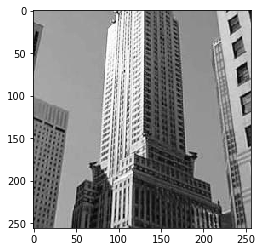

In [19]:
### show a sample classification ###
plot_file(test_filenames[3])
print 'true label:',test_labels[3]
hybrid_feature_vector=extract_daisy_hog_hybrid_feature_from_image(test_filenames[3],daisy_cluster_model)
print 'prediction:',hybrid_classifier.predict([hybrid_feature_vector])

Prediction: [ 7.]


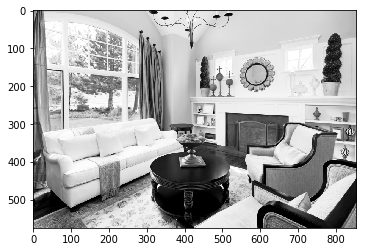

In [20]:
### show a sample classification on external file ###
external_file_name="test/l1.jpg"
plot_file(external_file_name)
hybrid_feature_vector=extract_daisy_hog_hybrid_feature_from_image(external_file_name,daisy_cluster_model)
print 'Prediction:',hybrid_classifier.predict([hybrid_feature_vector])

In [21]:
### testing data feature extraction ###, do only for 200 instances if a quick test is required
XTEST=[]
YTEST=[]
for i in tqdm(range(len(test_filenames))):
    XTEST.append(extract_daisy_hog_hybrid_feature_from_image(test_filenames[i],daisy_cluster_model))
    YTEST.append(test_labels[i])

100%|██████████| 2691/2691 [11:51<00:00,  4.40it/s]


In [22]:
print 'Hybrid Classifier Mertics'
print 'No. of test instances:',len(XTEST),len(YTEST)
### Accuracy Report ###
hybridpred=hybrid_classifier.predict(XTEST)
print 'Overall accuracy:',accuracy_score(YTEST,hybridpred)
print classification_report(YTEST, hybridpred, target_names=category_names)
print 'Confusion matrix:\n'
pd.DataFrame(confusion_matrix(YTEST,hybridpred),
             columns=['MITinsidecity', 'bedroom', 'PARoffice', 'MITmountain', 'MITtallbuilding', 'MIThighway', 'MITcoast', 'livingroom', 'industrial', 'store', 'MITopencountry', 'MITstreet', 'MITforest', 'kitchen', 'CALsuburb'],
               index=['MITinsidecity', 'bedroom', 'PARoffice', 'MITmountain', 'MITtallbuilding', 'MIThighway', 'MITcoast', 'livingroom', 'industrial', 'store', 'MITopencountry', 'MITstreet', 'MITforest', 'kitchen', 'CALsuburb'])


Hybrid Classifier Mertics
No. of test instances: 2691 2691
Overall accuracy: 0.764399851356
                 precision    recall  f1-score   support

  MITinsidecity       0.74      0.80      0.77       184
        bedroom       0.56      0.33      0.41       134
      PARoffice       0.71      0.86      0.78       129
    MITmountain       0.85      0.83      0.84       217
MITtallbuilding       0.84      0.83      0.83       222
     MIThighway       0.88      0.86      0.87       157
       MITcoast       0.79      0.81      0.80       212
     livingroom       0.62      0.55      0.59       190
     industrial       0.76      0.56      0.65       201
          store       0.59      0.80      0.68       174
 MITopencountry       0.69      0.80      0.74       225
      MITstreet       0.93      0.81      0.87       183
      MITforest       0.83      0.93      0.88       178
        kitchen       0.61      0.62      0.61       125
      CALsuburb       1.00      0.96      0.98      

,MITinsidecity,bedroom,PARoffice,MITmountain,MITtallbuilding,MIThighway,MITcoast,livingroom,industrial,store,MITopencountry,MITstreet,MITforest,kitchen,CALsuburb
MITinsidecity,148,0,0,0,7,2,1,0,4,11,1,6,1,3,0
bedroom,0,44,16,1,1,0,1,31,8,12,0,0,0,20,0
PARoffice,0,2,111,0,0,0,0,6,0,3,0,0,0,7,0
MITmountain,0,0,0,181,1,1,8,0,0,1,17,0,8,0,0
MITtallbuilding,9,0,1,2,184,0,1,3,7,6,1,1,7,0,0
MIThighway,3,0,0,0,0,135,4,0,2,3,8,1,1,0,0
MITcoast,0,0,0,0,0,2,172,0,0,0,36,0,2,0,0
livingroom,2,18,11,1,1,0,1,105,5,30,1,0,0,15,0
industrial,19,3,4,5,14,5,7,3,113,16,6,2,2,2,0
store,7,2,2,1,0,0,3,7,3,140,2,1,3,3,0


### Linear Classifier Tests:

In [23]:
#### TRAIN A linear SVM CLASSIFIER and GET ACCURACY REPORT ###
hybrid_classifier=svm.LinearSVC()
hybrid_classifier.fit(XTRAIN,YTRAIN)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [24]:
print 'Hybrid Classifier Mertics - Linear SVM'
print 'No. of test instances:',len(XTEST),len(YTEST)
### Accuracy Report ###
hybridpred=hybrid_classifier.predict(XTEST)
print 'Overall accuracy:',accuracy_score(YTEST,hybridpred)
print classification_report(YTEST, hybridpred, target_names=category_names)
print 'Confusion matrix:\n'
pd.DataFrame(confusion_matrix(YTEST,hybridpred),
             columns=['MITinsidecity', 'bedroom', 'PARoffice', 'MITmountain', 'MITtallbuilding', 'MIThighway', 'MITcoast', 'livingroom', 'industrial', 'store', 'MITopencountry', 'MITstreet', 'MITforest', 'kitchen', 'CALsuburb'],
               index=['MITinsidecity', 'bedroom', 'PARoffice', 'MITmountain', 'MITtallbuilding', 'MIThighway', 'MITcoast', 'livingroom', 'industrial', 'store', 'MITopencountry', 'MITstreet', 'MITforest', 'kitchen', 'CALsuburb'])

Hybrid Classifier Mertics - Linear SVM
No. of test instances: 2691 2691
Overall accuracy: 0.755109624675
                 precision    recall  f1-score   support

  MITinsidecity       0.71      0.78      0.74       184
        bedroom       0.57      0.42      0.48       134
      PARoffice       0.75      0.85      0.80       129
    MITmountain       0.85      0.85      0.85       217
MITtallbuilding       0.75      0.85      0.80       222
     MIThighway       0.87      0.87      0.87       157
       MITcoast       0.79      0.80      0.79       212
     livingroom       0.63      0.48      0.54       190
     industrial       0.82      0.53      0.64       201
          store       0.61      0.77      0.68       174
 MITopencountry       0.69      0.75      0.71       225
      MITstreet       0.84      0.83      0.83       183
      MITforest       0.80      0.93      0.86       178
        kitchen       0.62      0.58      0.60       125
      CALsuburb       0.96      0.97   

,MITinsidecity,bedroom,PARoffice,MITmountain,MITtallbuilding,MIThighway,MITcoast,livingroom,industrial,store,MITopencountry,MITstreet,MITforest,kitchen,CALsuburb
MITinsidecity,143,0,1,0,12,0,1,0,5,12,3,5,1,1,0
bedroom,0,56,11,1,2,0,1,28,4,9,0,4,1,16,1
PARoffice,0,4,110,0,1,0,1,5,0,3,0,0,0,5,0
MITmountain,1,0,0,185,0,1,7,0,1,2,10,1,9,0,0
MITtallbuilding,11,0,1,1,189,0,1,1,2,6,1,2,7,0,0
MIThighway,3,0,0,2,0,136,3,0,1,0,9,2,1,0,0
MITcoast,0,0,0,0,0,5,169,0,0,0,36,0,2,0,0
livingroom,2,25,9,1,5,0,0,91,3,30,1,3,0,17,3
industrial,18,2,4,3,22,4,6,1,107,10,9,8,4,2,1
store,5,1,2,6,3,0,3,5,4,134,2,1,3,4,1


### HOG only Tests:

In [25]:
XTRAIN_HOG=[]
for X in XTRAIN:
    XTRAIN_HOG.append(X[daisy_cluster_model.n_clusters:])

In [26]:
XTEST_HOG=[]
for X in XTEST:
    XTEST_HOG.append(X[daisy_cluster_model.n_clusters:])

In [27]:
#### TRAIN HOG only CLASSIFIER and GET ACCURACY REPORT ###
hogclassifier=svm.LinearSVC()
hogclassifier.fit(XTRAIN_HOG,YTRAIN)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [28]:
print 'HOG Only Classifier Mertics'
print 'No. of test instances:',len(XTEST_HOG),len(YTEST)
### Accuracy Report ###
pred=hogclassifier.predict(XTEST_HOG)
print 'Overall accuracy:',accuracy_score(YTEST,pred)
print classification_report(YTEST, pred, target_names=category_names)
print 'Confusion matrix:\n'
pd.DataFrame(confusion_matrix(YTEST,pred),
             columns=['MITinsidecity', 'bedroom', 'PARoffice', 'MITmountain', 'MITtallbuilding', 'MIThighway', 'MITcoast', 'livingroom', 'industrial', 'store', 'MITopencountry', 'MITstreet', 'MITforest', 'kitchen', 'CALsuburb'],
               index=['MITinsidecity', 'bedroom', 'PARoffice', 'MITmountain', 'MITtallbuilding', 'MIThighway', 'MITcoast', 'livingroom', 'industrial', 'store', 'MITopencountry', 'MITstreet', 'MITforest', 'kitchen', 'CALsuburb'])

HOG Only Classifier Mertics
No. of test instances: 2691 2691
Overall accuracy: 0.586027499071
                 precision    recall  f1-score   support

  MITinsidecity       0.51      0.62      0.56       184
        bedroom       0.39      0.32      0.35       134
      PARoffice       0.59      0.49      0.53       129
    MITmountain       0.68      0.63      0.65       217
MITtallbuilding       0.49      0.62      0.55       222
     MIThighway       0.84      0.59      0.69       157
       MITcoast       0.65      0.78      0.71       212
     livingroom       0.50      0.43      0.46       190
     industrial       0.50      0.20      0.29       201
          store       0.40      0.45      0.42       174
 MITopencountry       0.53      0.65      0.58       225
      MITstreet       0.72      0.76      0.74       183
      MITforest       0.65      0.88      0.75       178
        kitchen       0.47      0.36      0.41       125
      CALsuburb       0.87      0.84      0.86    

,MITinsidecity,bedroom,PARoffice,MITmountain,MITtallbuilding,MIThighway,MITcoast,livingroom,industrial,store,MITopencountry,MITstreet,MITforest,kitchen,CALsuburb
MITinsidecity,114,1,0,0,35,1,4,0,7,7,2,6,1,1,5
bedroom,2,43,12,4,6,0,1,32,4,11,1,3,2,12,1
PARoffice,10,6,63,1,13,0,0,8,3,11,0,4,0,9,1
MITmountain,1,1,0,137,1,2,10,0,0,1,36,3,24,0,1
MITtallbuilding,32,3,6,4,138,1,2,1,8,13,2,4,7,0,1
MIThighway,1,1,0,0,1,92,27,0,1,1,29,3,1,0,0
MITcoast,0,0,0,3,0,1,166,0,0,0,39,0,3,0,0
livingroom,5,39,5,1,8,0,0,82,4,29,0,0,1,14,2
industrial,28,4,5,7,45,0,7,8,41,14,8,11,11,5,7
store,12,3,6,12,12,0,6,9,9,79,2,4,9,10,1


### DAISY only Tests:

In [29]:
XTRAIN_DAISY=[]
for X in XTRAIN:
    XTRAIN_DAISY.append(X[:daisy_cluster_model.n_clusters])

In [30]:
XTEST_DAISY=[]
for X in XTEST:
    XTEST_DAISY.append(X[:daisy_cluster_model.n_clusters])

In [31]:
#### TRAIN DAISY only CLASSIFIER and GET ACCURACY REPORT ###
daisyclassifier=svm.LinearSVC()
daisyclassifier.fit(XTRAIN_DAISY,YTRAIN)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [32]:
print 'HOG Only Classifier Mertics'
print 'No. of test instances:',len(XTEST_DAISY),len(YTEST)
### Accuracy Report ###
pred = daisyclassifier.predict(XTEST_DAISY)
print 'Overall accuracy:',accuracy_score(YTEST,pred)
print classification_report(YTEST, pred, target_names=category_names)
print 'Confusion matrix:\n'
pd.DataFrame(confusion_matrix(YTEST,pred),
             columns=['MITinsidecity', 'bedroom', 'PARoffice', 'MITmountain', 'MITtallbuilding', 'MIThighway', 'MITcoast', 'livingroom', 'industrial', 'store', 'MITopencountry', 'MITstreet', 'MITforest', 'kitchen', 'CALsuburb'],
               index=['MITinsidecity', 'bedroom', 'PARoffice', 'MITmountain', 'MITtallbuilding', 'MIThighway', 'MITcoast', 'livingroom', 'industrial', 'store', 'MITopencountry', 'MITstreet', 'MITforest', 'kitchen', 'CALsuburb'])

HOG Only Classifier Mertics
No. of test instances: 2691 2691
Overall accuracy: 0.711259754738
                 precision    recall  f1-score   support

  MITinsidecity       0.64      0.71      0.67       184
        bedroom       0.49      0.37      0.42       134
      PARoffice       0.72      0.78      0.75       129
    MITmountain       0.84      0.82      0.83       217
MITtallbuilding       0.75      0.81      0.78       222
     MIThighway       0.80      0.80      0.80       157
       MITcoast       0.76      0.79      0.77       212
     livingroom       0.55      0.39      0.46       190
     industrial       0.77      0.44      0.56       201
          store       0.55      0.73      0.63       174
 MITopencountry       0.69      0.74      0.71       225
      MITstreet       0.80      0.83      0.81       183
      MITforest       0.80      0.92      0.86       178
        kitchen       0.47      0.49      0.48       125
      CALsuburb       0.89      0.94      0.91    

,MITinsidecity,bedroom,PARoffice,MITmountain,MITtallbuilding,MIThighway,MITcoast,livingroom,industrial,store,MITopencountry,MITstreet,MITforest,kitchen,CALsuburb
MITinsidecity,130,1,1,1,11,2,3,0,3,15,6,8,1,2,0
bedroom,1,49,12,1,5,0,1,25,4,10,0,2,1,22,1
PARoffice,0,6,101,0,2,0,1,9,2,3,0,0,0,5,0
MITmountain,1,0,0,178,1,0,7,0,1,3,14,2,9,0,1
MITtallbuilding,10,0,1,0,180,0,1,5,4,7,1,2,9,0,2
MIThighway,2,0,0,3,3,126,6,0,0,0,11,4,1,1,0
MITcoast,0,0,0,2,0,8,168,0,1,0,31,0,2,0,0
livingroom,5,19,12,1,12,0,2,75,4,26,1,1,0,26,6
industrial,15,9,1,4,17,9,7,8,88,11,4,10,3,9,6
store,9,1,3,4,2,0,3,4,6,127,1,5,4,3,2
